In [3]:

# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from darts.models import Prophet
import plotly.express as px
from datetime import datetime


from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.models import ExponentialSmoothing
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [4]:
RNA_Conc = pd.read_csv("https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/wastewater_by_county.csv")
Covid_Rate = pd.read_csv("https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/cases_by_county.csv")
Sale_to_List_table = pd.read_csv("Sales_to_List.csv")
SDU = pd.read_excel("Carlsbad_San_Diego_Unemployment.xlsx")
SanDiego_Employment = pd.read_csv("SDUT.csv", parse_dates=True, infer_datetime_format=True)

In [5]:
# Covid Cases and RNA level Processing

Covid_Rate.loc[Covid_Rate["name"] == "Miami-Dade County, FL"]
Sandy = Covid_Rate.loc[Covid_Rate["name"] == 'San Diego County, CA']
Miami_RNA = RNA_Conc.loc[RNA_Conc['name'] == "Miami-Dade County, FL"]
Miami_cases2 = Covid_Rate.loc[Covid_Rate["name"] == "Miami-Dade County, FL"]
Miami_2020_cases = Miami_cases2.loc[pd.to_datetime(Miami_cases2['date']).dt.year == 2020]
Miami_2020_cases.insert(2, "week", pd.to_datetime(Miami_2020_cases['date']).dt.week, True)
Miami_test_2020 = Miami_2020_cases.groupby(by = "week").sum()
Miami_RNA.insert(2, "year", pd.to_datetime(Miami_RNA['sampling_week']).dt.year, True)
RNA_2020 = Miami_RNA.loc[Miami_RNA["year"] == 2020]
RNA_2020.insert(2, "week", pd.to_datetime(RNA_2020['sampling_week']).dt.week, True)
Cases_and_RNA = RNA_2020.merge(Miami_test_2020, how='inner', on='week')
Cases_and_RNA["Month"] = pd.to_datetime(Cases_and_RNA.sampling_week).dt.to_period('M')
Cases_and_RNA = Cases_and_RNA.drop(columns = "sampling_week")
Cases_and_RNA = Cases_and_RNA.drop(columns = "Unnamed: 0_x")
Cases_and_RNA = Cases_and_RNA.drop(columns = "Unnamed: 0_y")
Cases_and_RNA = Cases_and_RNA.drop(columns = ["fipscode_x", "fipscode_y"])


Miami_2021_cases = Miami_cases2.loc[pd.to_datetime(Miami_cases2['date']).dt.year == 2021]
Miami_2021_cases.insert(2, "week", pd.to_datetime(Miami_2021_cases['date']).dt.week, True)
Miami_test_2021 = Miami_2021_cases.groupby(by = "week").sum()


Miami_2022_cases = Miami_cases2.loc[pd.to_datetime(Miami_cases2['date']).dt.year == 2022]
Miami_2022_cases.insert(2, "week", pd.to_datetime(Miami_2022_cases['date']).dt.week, True)
Miami_test_2022 = Miami_2022_cases.groupby(by = "week").sum()

kent = pd.concat([Miami_test_2020, Miami_test_2021, Miami_test_2022], ignore_index=True)

Total_2021_cases = Covid_Rate.loc[pd.to_datetime(Covid_Rate['date']).dt.year == 2021]
Total_2021_cases.insert(2, "week", pd.to_datetime(Total_2021_cases['date']).dt.week, True)
Total_test_2021 = Total_2021_cases.groupby(by = "week").sum()




C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have b

In [6]:
# Percent of Sales under/over List: Ratio of sales where Sale Price below/above the final list price; excludes homes sold for exactly the list price.

below_list = pd.read_csv("Metro_pct_sold_below_list_uc_sfrcondo_sm_week.csv")

tblow_list = below_list.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
sandy_temp = tblow_list[17].to_frame()
Below_List_Price = sandy_temp.drop(["RegionName"])
dates = pd.to_datetime(Below_List_Price.index)
list_below_ratio = Below_List_Price[17].values
skice = {"Dates" : dates, "Percentage sold Under List Price" :list_below_ratio}
B_low_list = pd.DataFrame(data=skice)


above_list = pd.read_csv("Metro_pct_sold_above_list_uc_sfrcondo_week.csv")

tabov_list = above_list.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
sandy_temp_abov = tabov_list[17].to_frame()
Abov_List_Price = sandy_temp_abov.drop(["RegionName"])
dates_above = pd.to_datetime(Abov_List_Price.index)
list_above_ratio = Abov_List_Price[17].values
bove = {"Dates" : dates_above, "Percentage sold above list price" :list_above_ratio}
Percent_above_list_price = pd.DataFrame(data=bove)



# Median Sale Price: The median price at which homes across various geographies were sold.
Median_Sale_List = pd.read_csv("Metro_median_sale_to_list_uc_sfrcondo_sm_week.csv")

Median_list = Median_Sale_List.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
sandy_median = Median_list[17].to_frame()
Median_List_Price = sandy_median.drop(["RegionName"])
dates_median = pd.to_datetime(Median_List_Price.index)
medin_prices = Median_List_Price[17].values
medi = {"Dates" : dates_median, "Median sale to list Ratio" :medin_prices}
Median_sale_to_list_price = pd.DataFrame(data=medi)

# Days to Close (mean/median): Number of days between the listing going pending and the sale date.
Median_Close = pd.read_csv("Metro_median_days_to_close_uc_sfrcondo_sm_week.csv")

Median_clos = Median_Close.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
sandy_median_close = Median_clos[17].to_frame()
Median_Close_Price = sandy_median_close.drop(["RegionName"])
dates_median_close = pd.to_datetime(Median_Close_Price.index)
clos_prices = Median_Close_Price[17].values
med_clos = {"Dates" : dates_median_close, "Median days to close" :clos_prices}
Median_closing_days = pd.DataFrame(data=med_clos)

# Sale-to-List Ratio (mean/median): Ratio of sale vs. final list price.

# Price home actually sold for (sale) versus prices that home was listed online for (list)
Mean_Sale_List = pd.read_csv("Metro_mean_sale_to_list_uc_sfrcondo_sm_week.csv")

Mean_sales = Mean_Sale_List.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
mean_sales = Mean_sales[17].to_frame()
Mean_sales_Price = mean_sales.drop(["RegionName"])
dates_mean_sales = pd.to_datetime(Mean_sales_Price.index)
mean_prices = Mean_sales_Price[17].values
mean_sal = {"Dates" : dates_mean_sales, "Mean Sales to List Ratio" :mean_prices}
Mean_Selling_price = pd.DataFrame(data=mean_sal)


# Days to Close (mean/median): Number of days between the listing going pending and the sale date.
Mean_Close = pd.read_csv("Metro_mean_days_to_close_uc_sfrcondo_sm_week.csv")

mean_close_close = Mean_Close.drop(columns = ["RegionID","SizeRank","RegionType","StateName"]).T
mean_close_close = mean_close_close[17].to_frame()
mean_close_close_Price = mean_close_close.drop(["RegionName"])
dates_mean_close_close = pd.to_datetime(mean_close_close_Price.index)
mean_close_prices = mean_close_close_Price[17].values
mean_close_sal = {"Dates" : dates_mean_close_close, "Mean Days to Close" :mean_close_prices}
mean_close__days = pd.DataFrame(data=mean_close_sal)


In [7]:
sam = Median_closing_days.merge(Mean_Selling_price, how='inner', on='Dates')
samantha = mean_close__days.merge(Median_sale_to_list_price, how='inner', on='Dates')
simon = Percent_above_list_price.merge(B_low_list, how='inner', on='Dates')
tenten = sam.merge(samantha,how="inner", on= 'Dates').merge(simon, how = "inner", on= "Dates")




In [16]:
mean_close__days.head(3)

,Dates,Mean Days to Close
0,2018-01-27,36.0
1,2018-02-03,36.0
2,2018-02-10,35.0


In [17]:
series_mean_close_days = TimeSeries.from_dataframe(mean_close__days.set_index(["Dates"]))
series_mean_selling = TimeSeries.from_dataframe(Mean_Selling_price.set_index(["Dates"]))
series_median_sale_to_list = TimeSeries.from_dataframe(Median_sale_to_list_price.set_index(["Dates"]))
series_median_close_days = TimeSeries.from_dataframe(Median_closing_days.set_index(["Dates"]))
series_above_list = TimeSeries.from_dataframe(Percent_above_list_price.set_index(["Dates"]))
seroes_below_list = TimeSeries.from_dataframe(B_low_list.set_index(["Dates"]))
# kent

In [18]:
#TimeSeries.from_dataframe(Mean_Selling_price.set_index(["Dates"]))

In [ ]:
TimeSeries.from_dataframe

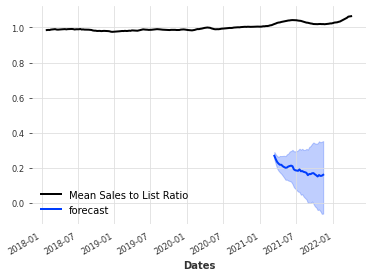

In [19]:
seroes_below_list
train, val = seroes_below_list[:-56], seroes_below_list[-56:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

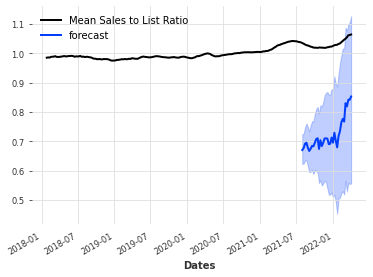

In [21]:
train, val = series_above_list[:-36], series_above_list[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

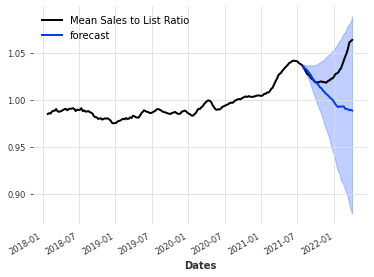

In [22]:
train, val = series_mean_selling[:-36], series_mean_selling[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [23]:
train, val = series_mean_close_days[:-36], series_mean_close_days[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

C:\Users\IanAK\miniconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\exponential_smoothing\initialization.py:96: RuntimeWarning: Mean of empty slice
  tmp.reshape(k_cycles, seasonal_periods).T, axis=1)


ValueError: shapes (2,10) and (0,1) not aligned: 10 (dim 1) != 0 (dim 0)

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')

In [ ]:
series = AirPassengersDataset().load()
train, val = series[:-36], series[-36:]

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(n=36, num_samples=500)

series.plot()
pred.plot(label='forecast')